# Attention is All You Need! 

Attention mechanisms,  are a cornerstone of modern natural language processing and form the heart of GPT (Generative Pre-trained Transformer) models and Vision Transformers.

The following method is based on  [the paper introducing Transformer architecture by Vaswani et al](https://arxiv.org/abs/1706.03762). 

#### What is Self-Attention?
The term "self" in self-attention refers to the model's ability to find relationships within its own input. Attention, in this context, means focusing on specific parts of the input. By combining these concepts, self-attention allows neural network models to learn how to focus on specific parts of the input when producing an output. In the context of language models like GPT, attention enables the model to consider relevant words or phrases when predicting the next word, regardless of their position in the sentence.

GPT models incorporate self-attention within their transformer architecture. The attention mechanism is integrated into the GPT framework through the following components:

### Embedding Layer: 
This initial step transforms words into numerical vectors.

### Positional Encoder: 
Information about word order is incorporated into the embedded vectors.

### Transformer Blocks: 
These are the core processing units, consisting of multiple layers. Each layer contains:

### Multi-Head Attention:
This allows the model to focus on various aspects of the input concurrently.

### Feed-Forward Neural Network:
This component further processes the output from the attention mechanism.


### Output Layer: 
The final stage that generates probabilities for predicting the next word in the sequence.

In our upcoming exploration, we will implement these attention mechanisms and provide visualizations to help you gain a comprehensive understanding of how GPT models interpret and generate text.

Are you ready to delve into the fascinating realm of attention in large language models? Let's Go!!!

## Query (Q), Key (K), Value (V)

In [2]:
!pip install seaborn

In [3]:
import math
import base64
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.show_mermaid import mm
from IPython.display import Image, display

In [4]:
# Create the src directory if it doesn't exist
import os
os.makedirs('src', exist_ok=True)

In [5]:
#  Define your example sentence

sentence = "The experience gain from your own failure will be long lasting"
# sentence = "Think of humanity on the path towards more unfathomable complexity"


Let's use a simplfied representation of this sentence where each element is either "0" or "1"with 3 dimensions. We could think of these 3 dimensions as representing very basic linguistic features. For example:
1. First dimension could represent "action" or "concreteness"
2. Second dimension: Could represent "relation" or "abstractness"
3. Third dimension: Could represent "complexity" or "plurality".

Thus, a word "think" can be represented as [1, 0, 0] since it is an action verb, concrete, singular, while "of" as [0, 1, 0] since it is a relational word, abstract, singular. 

In [6]:
word_to_vec = {
    "The": [1, 0, 0],
    "experience": [0, 1, 0],
    "gain": [1, 0, 1],
    "from": [0, 1, 1],
    "your": [1, 1, 1],
    "own": [1, 0, 0],
    "failure": [1, 1, 0],
    "will": [0, 0, 1],
    "be": [1, 0, 1],
    "long": [0, 1, 1],
    "lasting":[1, 1, 0],
}

In [7]:
for word, vector in word_to_vec.items():
    print(f"{word}: {vector}")

The: [1, 0, 0]
experience: [0, 1, 0]
gain: [1, 0, 1]
from: [0, 1, 1]
your: [1, 1, 1]
own: [1, 0, 0]
failure: [1, 1, 0]
will: [0, 0, 1]
be: [1, 0, 1]
long: [0, 1, 1]
lasting: [1, 1, 0]


In [8]:
words = sentence.split()
query = torch.tensor([word_to_vec["failure"]], dtype=torch.float)  # We're querying with the specific word
key = torch.tensor([word_to_vec[word] for word in words], dtype=torch.float)
value = torch.tensor([[i] for i in range(len(words))], dtype=torch.float)

In [9]:
print("Query shape:", query.shape)
print("Key shape:", key.shape)
print("Value shape:", value.shape)

Query shape: torch.Size([1, 3])
Key shape: torch.Size([11, 3])
Value shape: torch.Size([11, 1])


The attention scores are calculated by performing a dot product operation between the query vector and each key vector (representing words in the sentence). This dot product serves as a measure of similarity. In this simplified representation:

- Words whose vectors match "path" ([1, 0, 0]) exactly will yield a score of 1.
- Words with entirely dissimilar vectors will produce a score of 0.
- Words with partial vector overlap will result in scores ranging from 0 to 1.

In [10]:
scores = query @ key.T
print("\nAttention Scores:", scores)


Attention Scores: tensor([[1., 1., 1., 1., 2., 1., 2., 0., 1., 1., 2.]])


The softmax function turns these scores into a probability distribution. This step:
1. Ensures all weights are between 0 and 1.
2. Makes the weights sum to 1.
3. Enhances the differences between scores, making high scores even higher and low scores lower.

In [11]:
attention_weights = F.softmax(scores, dim=-1)
print("Attention Weights:", attention_weights)

Attention Weights: tensor([[0.0644, 0.0644, 0.0644, 0.0644, 0.1751, 0.0644, 0.1751, 0.0237, 0.0644,
         0.0644, 0.1751]])


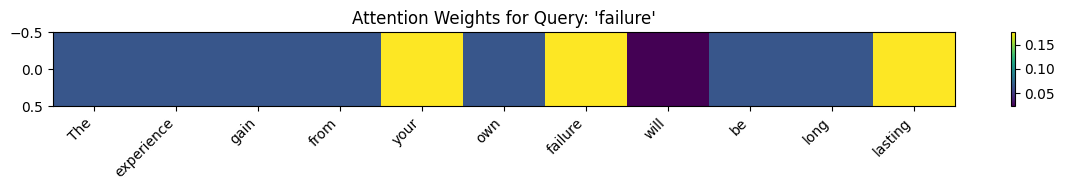

In [12]:
# Visualize attention weights
# Think what words contribute most to the query word's representation
query_word = "failure"

plt.figure(figsize=(12, 2))
plt.imshow(F.softmax(query @ key.T, dim=-1).detach(), cmap='viridis', aspect='auto')
plt.title(f"Attention Weights for Query: '{query_word}'")
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.colorbar()
plt.tight_layout()
plt.show()

We calculate an attention-weighted average by multiplying each word's position by its attention weight and summing the results. This process, equivalent to matrix multiplication, produces a weighted average position in the sentence. Words with higher attention weights contribute more significantly to this final position.

In [13]:
# Show the step-by-step calculation for weighted average
print("\nStep-by-step calculation for a weghted sum:")
for i, (weight, val) in enumerate(zip(attention_weights[0], value)):
    print(f"Word {i}: {weight.item():.2f} * {val.item()} = {weight.item()*val.item():.2f}")


Step-by-step calculation for a weghted sum:
Word 0: 0.06 * 0.0 = 0.00
Word 1: 0.06 * 1.0 = 0.06
Word 2: 0.06 * 2.0 = 0.13
Word 3: 0.06 * 3.0 = 0.19
Word 4: 0.18 * 4.0 = 0.70
Word 5: 0.06 * 5.0 = 0.32
Word 6: 0.18 * 6.0 = 1.05
Word 7: 0.02 * 7.0 = 0.17
Word 8: 0.06 * 8.0 = 0.52
Word 9: 0.06 * 9.0 = 0.58
Word 10: 0.18 * 10.0 = 1.75


In [14]:
output = attention_weights @ value
print("Weighted sum also referred to as a context vector:", output)

Weighted sum also referred to as a context vector: tensor([[5.4720]])


In [15]:
mm("""
graph TD
    A[Input Sequence] --> B[Query Q]
    A --> C[Key K]
    A --> D[Value V]
    B --> E[Compute Attention Scores]
    C --> E
    E --> F[Apply Softmax]
    F --> G[Weighted Sum]
    D --> G
    G --> H[Output]
""")

## 1. Dot-Product Attention

In [16]:
def dot_product_attention(query, key, value):
    # Implement dot-product attention    
    attention_scores = query @ key.T
    attention_weights = torch.softmax(attention_scores, dim=-1)
    value_for_word = attention_weights @ value
    
    return value_for_word

In [17]:
output = dot_product_attention(query, key, value)
print("Dot-Product Attention Output:", output)

Dot-Product Attention Output: tensor([[5.4720]])


## 2. Scaled Dot-Product Attention

Scaled attention incorporates a scaling factor: the square root of the key vector's dimension. This scaling is crucial for several reasons:

1. The magnitude of dot products tends to increase with higher-dimensional key vectors.
2. Excessively large dot products can push the softmax function into areas with negligible (very small) gradients.
3. This can result in either extremely sharp (almost one-hot) distributions post-softmax, or disappearing gradients.

In [18]:
def scaled_dot_product_attention(query, key, value):
    # Implement scaled dot-product attention    
    attention_scores = query @ key.T
    
    attention_weights = torch.softmax(attention_scores/ key.shape[-1]**0.5, dim=-1)
    weighted_sum = attention_weights @ value
    
    return weighted_sum, attention_weights

In [19]:
output_scaled,_ = scaled_dot_product_attention(query, key, value)
print("Scaled Dot-Product Attention Output:", output_scaled)

Scaled Dot-Product Attention Output: tensor([[5.2347]])


## 3. Self-Attention

Self-attention employs input projections rather than using the input directly for query, key, and value. These projections enable the model to transform the input into various representation spaces, potentially with different dimensions.

The projection process utilizes the dot product because it effectively measures the alignment between vectors. This alignment measurement is precisely what projection aims to capture, making the dot product an ideal mathematical tool for this purpose.

In [20]:

x = torch.tensor([word_to_vec[word] for word in words], dtype=torch.float)

We'd now review the concept of linear transfomation and `nn.Linear`. When we apply the linear layer, it performs the following operation for each sequence element:
output = x @ weight.T + bias

In [21]:
# Let's create a simple example
input_dim = x.shape[1]
out_dim = 3
seq_length = 2
batch_size = 1

# Create an nn.Linear layer
linear_layer = nn.Linear(input_dim, out_dim)

# Print the weight matrix and bias
print("Weight matrix shape:", linear_layer.weight.shape)
print("Weight matrix:")
print(linear_layer.weight.data)
print("\nBias shape:", linear_layer.bias.shape)
print("Bias:")
print(linear_layer.bias.data)

Weight matrix shape: torch.Size([3, 3])
Weight matrix:
tensor([[-0.4149,  0.5697, -0.1206],
        [ 0.0077,  0.5749, -0.1350],
        [-0.1365, -0.3047, -0.2717]])

Bias shape: torch.Size([3])
Bias:
tensor([ 0.0273, -0.4523,  0.2746])


In [22]:
print("\nInput shape:", x.shape)
print("Input:")
print(x)


Input shape: torch.Size([11, 3])
Input:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.],
        [1., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 0.]])


In [23]:
# Apply the linear transformation
output = linear_layer(x)

print("\nOutput shape:", output.shape)
print("Output:")
print(output)


Output shape: torch.Size([11, 3])
Output:
tensor([[-0.3876, -0.4446,  0.1381],
        [ 0.5970,  0.1226, -0.0300],
        [-0.5083, -0.5796, -0.1336],
        [ 0.4764, -0.0124, -0.3017],
        [ 0.0614, -0.0047, -0.4382],
        [-0.3876, -0.4446,  0.1381],
        [ 0.1820,  0.1303, -0.1666],
        [-0.0933, -0.5873,  0.0030],
        [-0.5083, -0.5796, -0.1336],
        [ 0.4764, -0.0124, -0.3017],
        [ 0.1820,  0.1303, -0.1666]], grad_fn=<AddmmBackward0>)


In [24]:
# Verification with the dot product
manual_output = torch.matmul(x, linear_layer.weight.t()) + linear_layer.bias
print("\nManual calculation output:")
print(manual_output)
print("\nDoes manual calculation match nn.Linear output?", torch.allclose(output, manual_output))


Manual calculation output:
tensor([[-0.3876, -0.4446,  0.1381],
        [ 0.5970,  0.1226, -0.0300],
        [-0.5083, -0.5796, -0.1336],
        [ 0.4764, -0.0124, -0.3017],
        [ 0.0614, -0.0047, -0.4382],
        [-0.3876, -0.4446,  0.1381],
        [ 0.1820,  0.1303, -0.1666],
        [-0.0933, -0.5873,  0.0030],
        [-0.5083, -0.5796, -0.1336],
        [ 0.4764, -0.0124, -0.3017],
        [ 0.1820,  0.1303, -0.1666]], grad_fn=<AddBackward0>)

Does manual calculation match nn.Linear output? True


Self-attention distinguishes itself from standard scaled dot-product attention by employing learned projections (Q, K, V) rather than directly utilizing the input. This mechanism enables each sequence position to consider all positions, including its own.
The nn.Linear layers play a vital role in this process:

They incorporate trainable parameters, enabling the model to fine-tune its input projection method for attention calculations.
These layers allow the model to transform the input in task-specific ways, a skill acquired during the training phase.

In [25]:
class SimpleSelfAttention(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(SimpleSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim

        # Create linear projections for Q, K, V
        self.q_proj = nn.Linear(input_dim, out_dim)
        self.k_proj = nn.Linear(input_dim, out_dim)
        self.v_proj = nn.Linear(input_dim, out_dim)
        
        self.fc_out = nn.Linear(out_dim, input_dim) # -> (batch_size, seq_length, input_dim)

    def forward(self, x):
        # Implement SimpleSelfAttention class forward()

        query = self.q_proj(x) 
        key = self.k_proj(x) 
        value = self.v_proj(x) 
        output_scaled,attention_weights = scaled_dot_product_attention(query, key, value)
        output = self.fc_out(output_scaled)
        return output,attention_weights




In [26]:
self_attention = SimpleSelfAttention(input_dim, out_dim)
output, attention_weights = self_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: torch.Size([11, 3])
Output shape: torch.Size([11, 3])
Attention weights shape: torch.Size([11, 11])


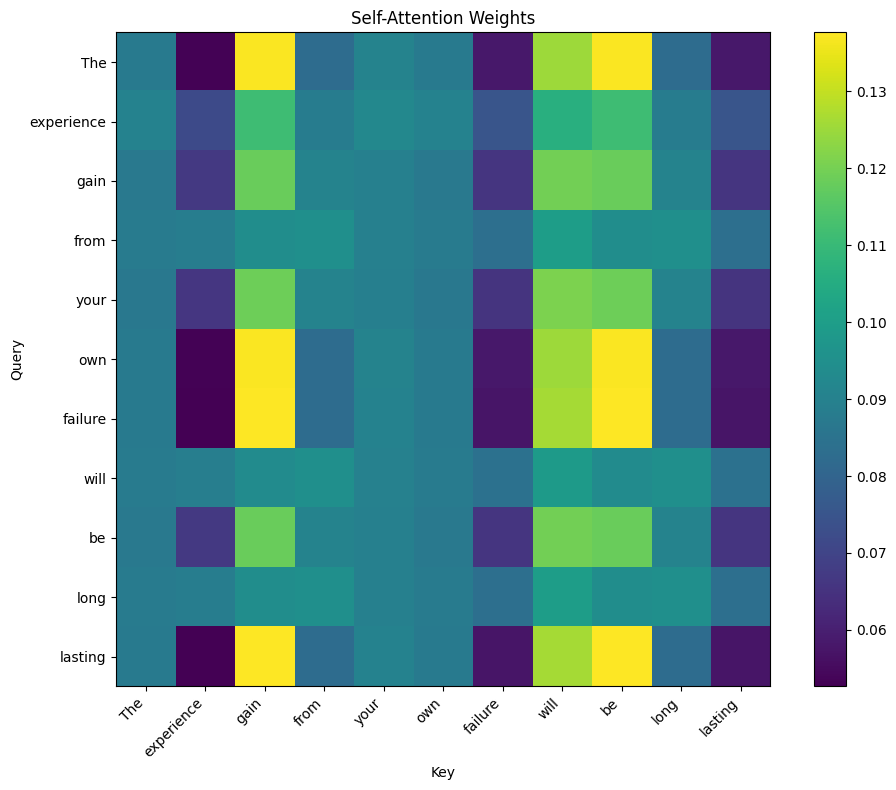

In [27]:
# Visualize attention weights
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights.detach().numpy(), cmap='viridis')  # Convert to numpy if needed
plt.title("Self-Attention Weights")
plt.xlabel("Key")
plt.ylabel("Query")
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.colorbar()
plt.tight_layout()
plt.show()

## 4. Causal Attention with Masking

In GPT models, the autoregressive nature plays a crucial role. This property describes a key characteristic where each prediction relies solely on information from preceding elements. In other words, when generating or processing a sequence, the model considers only what has come before, not what follows.

Causal Attention: A Key Concept in Sequential Processing

Causal attention, also referred to as masked attention, is a specialized variant of the self-attention mechanism. Its defining characteristic is the constraint it imposes on information flow within a sequence:

1. Sequential Processing: When dealing with any specific token in a sequence, the model is limited to considering only the current token and those that precede it.

2. Forward-Only Context: This mechanism effectively creates a one-way or "causal" relationship in the data, where each element is influenced solely by its predecessors.

3. Preventing Information Leakage: By design, causal attention ensures that no future information can impact the processing of the current token, maintaining the integrity of sequential prediction tasks.

This approach is particularly crucial in autoregressive models like GPT, where maintaining the temporal order of information is essential for tasks such as text generation and sequential prediction.

From the math perspective, `torch.triu` creates an upper triangular matrix from an input tensor with the main diagonal and above. It's often used to create masks for causal attention in transformer models.

In [28]:
matrix = torch.ones(5, 5)
print("Original matrix:")
print(matrix)

Original matrix:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [29]:
upper_triangular = torch.triu(matrix)
print("\nUpper triangular matrix:")
print(upper_triangular)


Upper triangular matrix:
tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])


In [30]:
# Offset the diagonal
offset_triangular = torch.triu(matrix, diagonal=1)
print("\nUpper triangular matrix with offset 1:")
print(offset_triangular)


Upper triangular matrix with offset 1:
tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])


In [31]:
# Make masked values be ignored also after Softmax
neg_inf = upper_triangular.masked_fill(upper_triangular == 0, float('-inf'))
neg_inf

tensor([[1., 1., 1., 1., 1.],
        [-inf, 1., 1., 1., 1.],
        [-inf, -inf, 1., 1., 1.],
        [-inf, -inf, -inf, 1., 1.],
        [-inf, -inf, -inf, -inf, 1.]])

Any `-inf` value in scores will result in a zero probability after applying the Softmax function, meaning those positions are ignored. This effectively ensures that each token can only attend to itself and the tokens before it in the sequence.

In [32]:
# Creating a boolean mask
mask = torch.triu(matrix, diagonal=1).bool()
print("\nBoolean mask for upper triangular with offset 1:")
print(mask)


Boolean mask for upper triangular with offset 1:
tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


In [33]:
class CausalSelfAttention(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(CausalSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim

        self.q_proj = nn.Linear(input_dim, out_dim)
        self.k_proj = nn.Linear(input_dim, out_dim)
        self.v_proj = nn.Linear(input_dim, out_dim)
        
        self.fc_out = nn.Linear(out_dim, input_dim)

    def forward(self, x):

        batch_size, seq_length, _ = x.size()

        # Implement CausalSelfAttention class forward pass
        query = self.q_proj(x) 
        key = self.k_proj(x) 
        value = self.v_proj(x) 
        
        # Compute attention scores
        
        attention_scores = query @ key.transpose(1, 2) 
        
        # Create causal mask
        causal_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(x.device)

        # Apply the causal mask: set future tokens' attention scores to -inf
        attention_scores = attention_scores.masked_fill(causal_mask, -torch.inf)
        attn_weights = torch.softmax(attention_scores / key.shape[-1]**0.5, dim=-1)

        attention_output = attn_weights @ value
        
        output = self.fc_out(attention_output)

        return output, attn_weights



In [34]:
x = x.unsqueeze(0)  # Add batch dimension
x.shape

torch.Size([1, 11, 3])

In [35]:
causal_attention = CausalSelfAttention(input_dim, out_dim)
output, attention_weights = causal_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: torch.Size([1, 11, 3])
Output shape: torch.Size([1, 11, 3])
Attention weights shape: torch.Size([1, 11, 11])


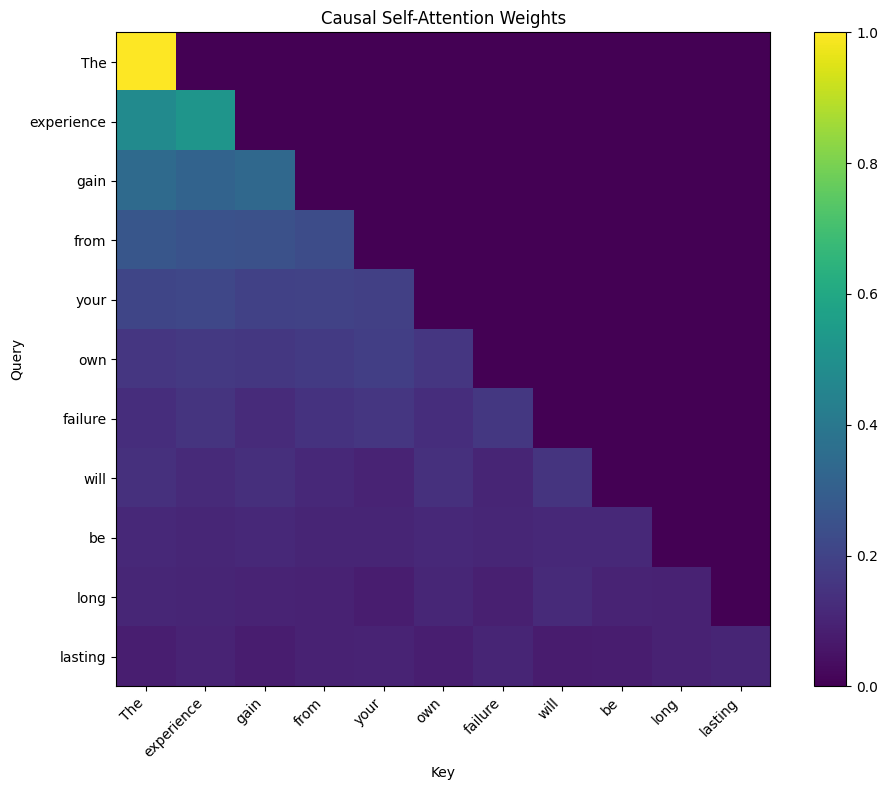

In [36]:
# Visualize attention weights
plt.figure(figsize=(10, 8))
plt.imshow(attention_weights[0].detach().numpy(), cmap='viridis')  # Convert to numpy if needed
plt.title("Causal Self-Attention Weights")
plt.xlabel("Key")
plt.ylabel("Query")
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.colorbar()
plt.tight_layout()
plt.show()


In [37]:
# Print transformed vectors for each word
print("\nTransformed word vectors:")
for i, word in enumerate(words):
    print(f"{word}: {output[0][i].detach().numpy()}")


Transformed word vectors:
The: [ 0.7199632  -0.27707222  0.102935  ]
experience: [ 0.61479276 -0.25941992  0.06852606]
gain: [ 0.69630307 -0.29387     0.10043719]
from: [ 0.6791526  -0.29977086  0.0970424 ]
your: [ 0.7005049  -0.34302673  0.0884209 ]
own: [ 0.7074903  -0.3399376   0.08993655]
failure: [ 0.7004207  -0.35659435  0.0742989 ]
will: [ 0.70044994 -0.3141088   0.09952047]
be: [ 0.7166428  -0.32717758  0.10192296]
long: [ 0.70578015 -0.32039765  0.10267815]
lasting: [ 0.7020148  -0.34805372  0.08394517]


#### Question to you

We now see how an autoregressive setting works with triangular mask. And that's the approach in decoder attention block. Thinking about encoder block and its setting of all tokens communicating with each other, what should we update in the current implementation of decoder to allow for this communication as in encoders? 

## 5. Multi-Head Attention

In [38]:
batch_size, seq_length, d_model = x.shape
num_heads = 3  # We'll use 3 heads since d_model is 3
head_dim = d_model // num_heads  # This will be 1 in this case

print(f"Input shape: {x.shape}")

Input shape: torch.Size([1, 11, 3])


In [39]:
# Linear projections
W_q = nn.Linear(d_model, d_model)
W_k = nn.Linear(d_model, d_model)
W_v = nn.Linear(d_model, d_model)

# Apply projections
Q = W_q(x)
K = W_k(x)
V = W_v(x)

print(f"\nShape after linear projection:")
print(f"Q shape: {Q.shape}")


Shape after linear projection:
Q shape: torch.Size([1, 11, 3])


#### Question to you

It won't be in our scope but have you thought of a "proper" weight initialization? If not but you want to think of it, check `xavier_uniform_`.

In [40]:
# Transpose to get dimensions [batch_size, num_heads, seq_len, head_dim]
Q = Q.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, seq_length, num_heads, head_dim).transpose(1, 2)

print(f"\nShape after reshaping for multi-head:")
print(f"Q shape: {Q.shape}")


Shape after reshaping for multi-head:
Q shape: torch.Size([1, 3, 11, 1])


In [41]:
# Perform attention for each head
scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)
attention_weights = torch.softmax(scores, dim=-1)
head_outputs = torch.matmul(attention_weights, V)

print(f"\nShape of each head's output:")
print(f"head_outputs shape: {head_outputs.shape}")


Shape of each head's output:
head_outputs shape: torch.Size([1, 3, 11, 1])


In [42]:
# Transpose and concatenate heads [batch_size, seq_len, d_model]
concat_heads = head_outputs.transpose(1, 2).contiguous().view(batch_size, seq_length, d_model)

print(f"\nShape after concatenating heads:")
print(f"concat_heads shape: {concat_heads.shape}")


Shape after concatenating heads:
concat_heads shape: torch.Size([1, 11, 3])


In [43]:
# Project final output
W_o = nn.Linear(d_model, d_model)
output = W_o(concat_heads)

print(f"\nFinal output shape:")
print(f"output shape: {output.shape}")


Final output shape:
output shape: torch.Size([1, 11, 3])


In [44]:
# Print attention weights for the first head
print(f"\nAttention weights for the first head:")
print(attention_weights[0, 0])


Attention weights for the first head:
tensor([[0.0981, 0.0753, 0.1038, 0.0797, 0.0950, 0.0981, 0.0898, 0.0870, 0.1038,
         0.0797, 0.0898],
        [0.0969, 0.0777, 0.1016, 0.0815, 0.0944, 0.0969, 0.0900, 0.0877, 0.1016,
         0.0815, 0.0900],
        [0.0981, 0.0753, 0.1038, 0.0797, 0.0950, 0.0981, 0.0898, 0.0870, 0.1038,
         0.0797, 0.0898],
        [0.0969, 0.0777, 0.1016, 0.0815, 0.0944, 0.0969, 0.0900, 0.0877, 0.1016,
         0.0815, 0.0900],
        [0.1046, 0.0619, 0.1171, 0.0692, 0.0982, 0.1046, 0.0878, 0.0825, 0.1171,
         0.0692, 0.0878],
        [0.0981, 0.0753, 0.1038, 0.0797, 0.0950, 0.0981, 0.0898, 0.0870, 0.1038,
         0.0797, 0.0898],
        [0.1046, 0.0619, 0.1171, 0.0692, 0.0982, 0.1046, 0.0878, 0.0825, 0.1171,
         0.0692, 0.0878],
        [0.0898, 0.0934, 0.0890, 0.0927, 0.0902, 0.0898, 0.0910, 0.0914, 0.0890,
         0.0927, 0.0910],
        [0.0981, 0.0753, 0.1038, 0.0797, 0.0950, 0.0981, 0.0898, 0.0870, 0.1038,
         0.0797, 0.0898]

In [52]:
%%writefile src/multiattention.py
import torch
import torch.nn as nn
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model # the output dimensionality
        self.num_heads = num_heads # the number of attention heads
        self.head_dim = d_model // num_heads # dimensionality of each head output

        # Making sure that each head will process a portion of the output
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"

        # Initialize weights for Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        # Scaling factor
        self.scale = self.head_dim ** -0.5
        # self.scale = 1 / math.sqrt(self.head_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_length = query.size(1)

        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2) 

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        attention_probs = torch.softmax(attention_scores, dim=-1)
        
        context = torch.matmul(attention_probs, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        output = self.W_o(context)
        
        return output, attention_probs

Overwriting src/multiattention.py


In [46]:
from src.multiattention import MultiHeadAttention

In [47]:
mha = MultiHeadAttention(d_model, num_heads)
output, attention_weights = mha(x, x, x)

In [49]:
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: torch.Size([1, 11, 3])
Output shape: torch.Size([1, 11, 3])
Attention weights shape: torch.Size([1, 3, 11, 11])


## 5. Attention Mechanism Visualization

In [50]:
def visualize_attention(attention_weights, words=None, title="Attention Weights"):
    """
    Visualize attention weights as a heatmap.
    
    Parameters:
    - attention_weights: torch.Tensor or numpy array of shape (seq_length, seq_length)
    - words: list of words corresponding to the sequence (optional)
    - title: title for the plot
    """
    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(10, 8))   
    sns.heatmap(attention_weights, 
                annot=True, 
                cmap='viridis', 
                ax=ax, 
                cbar=True,
                fmt='.2f')
    
    ax.set_title(title)
    if words:
        ax.set_xticks(range(len(words)))
        ax.set_yticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha='right')
        ax.set_yticklabels(words, rotation=0)
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')
    else:
        ax.set_xlabel('Sequence Position (Key)')
        ax.set_ylabel('Sequence Position (Query)')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

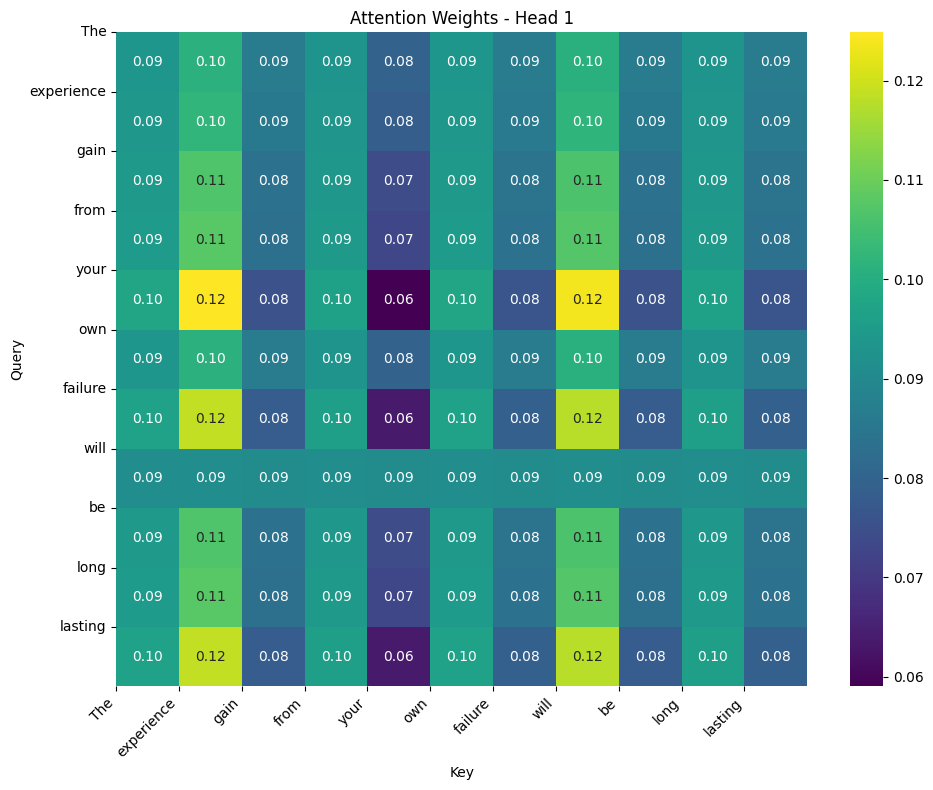

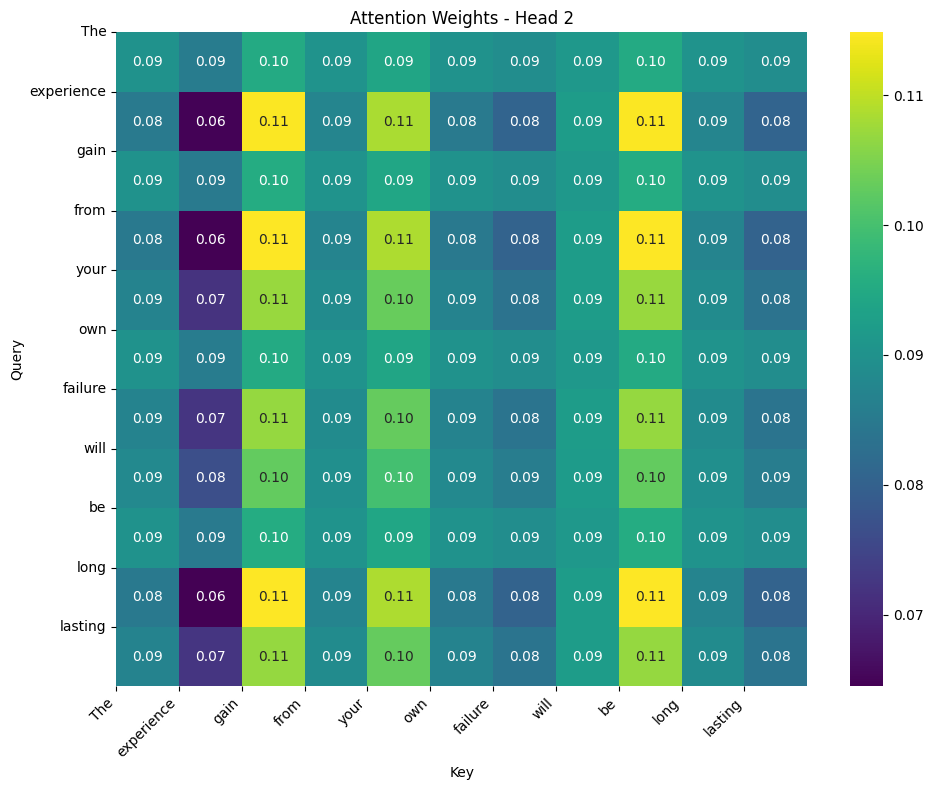

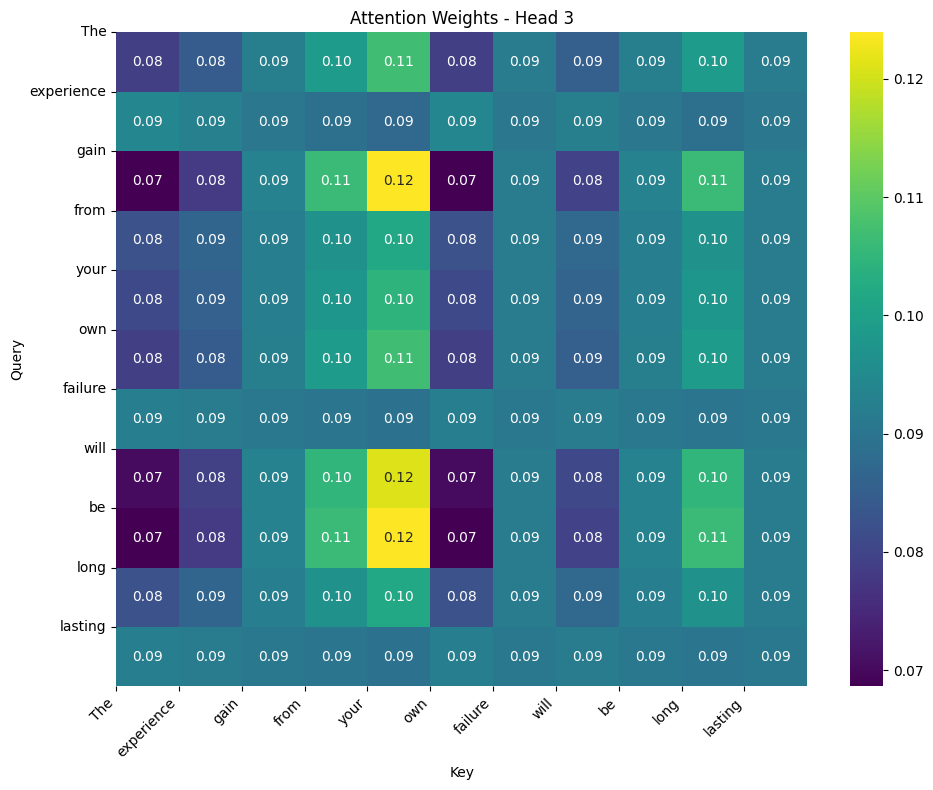

In [51]:
# Experiment with the input
# Not checking this but highly recommending

sentence = "The experience gain from your own failure will be long lasting"
words = sentence.split()

# Create input tensor
word_to_vec = {
    "The": [1, 0, 0],
    "experience": [0, 1, 0],
    "gain": [1, 0, 1],
    "from": [0, 1, 1],
    "your": [1, 1, 1],
    "own": [1, 0, 0],
    "failure": [1, 1, 0],
    "will": [0, 0, 1],
    "be": [1, 0, 1],
    "long": [0, 1, 1],
    "lasting":[1, 1, 0],
}

x = torch.tensor([word_to_vec[word] for word in words], dtype=torch.float).unsqueeze(0)

d_model = 3  # Dimension of our word vectors
num_heads = 3  # We'll use 3 heads for simplicity, but you can increase this
mha = MultiHeadAttention(d_model, num_heads)

# Get attention weights
_, attention_weights = mha(x, x, x)

# Visualize
for i in range(num_heads):
    visualize_attention(attention_weights[0, i], words, f"Attention Weights - Head {i+1}")

#### Congratulations! You've implemented various attention mechanisms and developed understanding by visualizing.